In [1]:
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jax import vmap
import jax.numpy as jnp
import jax.random as random
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm_notebook
import plotly.graph_objects as go
import re
from numpyro.contrib.tfp.distributions import ExpGamma
from numpyro.infer.initialization import init_to_value

numpyro.util.set_rng_seed(0)
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [2]:
# Create folder for storing results

time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
new_dir = os.path.join("../output/", "numpyro_nc_" + time)
os.mkdir(new_dir)

In [3]:
ITER = 500000
CHAINS = 4

In [4]:
def load_data():

    # Load Data

    df = pd.read_table("../data/rdata", header=None, delim_whitespace=True)
    df.columns = ["X", "Y"]
    df["index"] = np.where(df.index < 100, "Train", "Test")

    # Create train and test

    X_train = np.array(df.loc[df["index"] == "Train", "X"]).reshape(-1, 1)
    Y_train = np.array(df.loc[df["index"] == "Train", "Y"])
    X_test = np.array(df.loc[df["index"] == "Test", "X"]).reshape(-1, 1)
    Y_test = np.array(df.loc[df["index"] == "Test", "Y"])

    return X_train, X_test, Y_train, Y_test

In [5]:
X_train, X_test, Y_train, Y_test = load_data()

In [6]:
def model(x, y):
    
    # Hyperparameters
    
    w_ih_prec = numpyro.sample("w_ih_prec", ExpGamma(0.25, 0.000625))
    b_h_prec = numpyro.sample("b_h_prec", ExpGamma(0.25, 0.000625))
    w_ho_prec = numpyro.sample("w_ho_prec", ExpGamma(0.25, 0.000625))
    y_prec = numpyro.sample("y_prec", ExpGamma(0.25, 0.000625))
    
    # Low Level Parameters (non-centered)

    w_ih_raw = numpyro.sample("w_ih", dist.Normal(loc=jnp.zeros((1, 8)), scale=1))
    b_h_raw = numpyro.sample("b_h", dist.Normal(loc=jnp.zeros((1, 8)), scale=1))
    w_ho_raw = numpyro.sample("w_ho", dist.Normal(loc=jnp.zeros((8, 1)), scale=1))
    b_o_raw = numpyro.sample("b_o", dist.Normal(loc=jnp.zeros((1, 1)), scale=1))
    
    # Define intermediate parameters
    
    w_ih = (1/jnp.sqrt(jnp.exp(w_ih_prec))) * w_ih_raw
    b_h = (1/jnp.sqrt(jnp.exp(b_h_prec))) * b_h_raw
    w_ho = (1/jnp.sqrt(jnp.exp(w_ho_prec))) * w_ho_raw
    b_o = 100*b_o_raw
    
    # Forward Pass

    z1 = jnp.matmul(x, w_ih) + b_h
    a1 = jnp.tanh(z1)
    output = jnp.matmul(a1, w_ho) + b_o
    
    return numpyro.sample("y_pred", dist.Normal(output, 1/jnp.sqrt(jnp.exp(y_prec))), obs=y)
    # return numpyro.sample("y_pred", dist.Normal(output, 1/jnp.sqrt(y_prec))) #, obs=jnp.array([]))

In [7]:
init_values = {
    
    "w_ih_prec": 0.,
    "b_h_prec": 0.,
    "w_ho_prec": 0.,
    "y_prec": 0.,
    "w_ih": jnp.zeros((1, 8)),
    "b_h": jnp.zeros((1, 8)),
    "w_ho": jnp.zeros((8, 1)),
    "b_o": jnp.zeros((1, 1))
    
}

In [8]:
rng_key = random.PRNGKey(42)
rng_key, rng_key_predict = random.split(rng_key)

nuts_kernel = NUTS(model, adapt_mass_matrix=False, 
                  init_strategy=init_to_value(values=init_values))

mcmc = MCMC(nuts_kernel,
            num_samples=ITER,
            num_warmup=1000,
            num_chains=CHAINS,
            progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)

mcmc.run(rng_key,
         jnp.array(X_train.reshape((len(Y_train), 1))), 
         jnp.array(Y_train.reshape((len(Y_train), 1))))

mcmc.print_summary()

samples = mcmc.get_samples()






                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   b_h[0,0]      0.02      0.97      0.02     -1.61      1.58    614.06      1.01
   b_h[0,1]     -0.03      0.95     -0.02     -1.61      1.53    745.35      1.00
   b_h[0,2]     -0.02      0.98     -0.02     -1.61      1.62    677.06      1.01
   b_h[0,3]      0.04      0.97      0.06     -1.57      1.63    672.19      1.01
   b_h[0,4]      0.05      0.98      0.05     -1.55      1.67    783.11      1.00
   b_h[0,5]     -0.08      0.99     -0.07     -1.71      1.57    429.37      1.01
   b_h[0,6]     -0.00      0.95      0.00     -1.58      1.58    910.18      1.00
   b_h[0,7]      0.03      0.98      0.05     -1.60      1.63    674.92      1.01
   b_h_prec      4.79      2.89      5.73     -1.43      8.02     24.69      1.15
   b_o[0,0]      0.01      0.05      0.01     -0.05      0.07   3107.55      1.00
  w_ho[0,0]      0.07      1.02      0.09     -1.59      1.74    636.26      1.01
  w_ho[1,0]

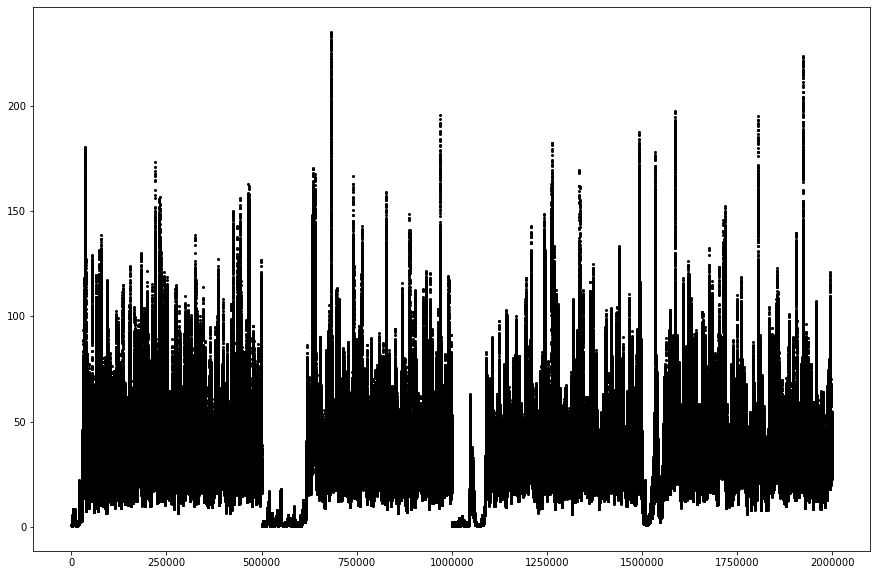

In [9]:
plt.figure(figsize = (15,10))
plt.plot(1/jnp.sqrt(jnp.exp(samples["w_ho_prec"])), "ko", markersize=2)

In [10]:
# TODO: can we make this more like tf_probability? The vmap function speeds it up.

def predict(model, rng_key, samples, X):
    
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    
    # note that Y will be sampled in the model because we pass Y=None here
    
    model_trace = handlers.trace(model).get_trace(x=X, y=None)
    
    return model_trace['y_pred']['value']

In [11]:
# Train and Test Predictions

# vmap_args = (samples, random.split(rng_key_predict, ITER * CHAINS))
# train_predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X_train))(*vmap_args)
# test_predictions = vmap(lambda samples, rng_key: predict(model, rng_key, samples, X_test))(*vmap_args)
# y_train_pred = train_predictions[..., 0]
# y_test_pred = test_predictions[..., 0]

In [12]:
# df_predictions_train = pd.DataFrame({
    
#     "inputs": X_train.flatten(),
#     "targets": Y_train.flatten(),
#     "mean": y_train_pred.mean(axis=0),
#     "median": np.quantile(y_train_pred, 0.5, axis=0),
#     "q1": np.quantile(y_train_pred, 0.01, axis=0),
#     "q10": np.quantile(y_train_pred, 0.10, axis=0),
#     "q90": np.quantile(y_train_pred, 0.90, axis=0),
#     "q99": np.quantile(y_train_pred, 0.99, axis=0),
#     "label": "train"

# })

# df_predictions_test = pd.DataFrame({
    
#     "inputs": X_test.flatten(),
#     "targets": Y_test.flatten(),
#     "mean": y_test_pred.mean(axis=0),
#     "median": np.quantile(y_test_pred, 0.5, axis=0),
#     "q1": np.quantile(y_test_pred, 0.01, axis=0),
#     "q10": np.quantile(y_test_pred, 0.10, axis=0),
#     "q90": np.quantile(y_test_pred, 0.90, axis=0),
#     "q99": np.quantile(y_test_pred, 0.99, axis=0),
#     "label": "test"

# })

# df = df_predictions_train.copy(deep=True)
# df = df.sort_values("inputs").reset_index()

# fig = go.Figure([
#     go.Scatter(
#         name='median',
#         x=df['inputs'],
#         y=df['median'],
#         mode='lines',
#         line=dict(color='rgb(31, 119, 180)'),
#     ),
#     go.Scatter(
#         name='Upper Bound',
#         x=df['inputs'],
#         y=df['q1'],
#         mode='lines',
#         marker=dict(color="#444"),
#         line=dict(width=0),
#         showlegend=False
#     ),
#     go.Scatter(
#         name='Lower Bound',
#         x=df['inputs'],
#         y=df['q99'],
#         marker=dict(color="#444"),
#         line=dict(width=0),
#         mode='lines',
#         fillcolor='rgba(68, 68, 68, 0.3)',
#         fill='tonexty',
#         showlegend=False
#     )
# ])

# fig.add_scatter(x=df['inputs'], y=df['targets'], mode="markers")

# fig.update_layout(
#     yaxis_title='Y',
#     title='Training Set',
#     hovermode="x"
# )
# fig.show()

# df = df_predictions_test.copy(deep=True)
# df = df.sort_values("inputs").reset_index()

# fig = go.Figure([
#     go.Scatter(
#         name='median',
#         x=df['inputs'],
#         y=df['median'],
#         mode='lines',
#         line=dict(color='rgb(31, 119, 180)'),
#     ),
#     go.Scatter(
#         name='Upper Bound',
#         x=df['inputs'],
#         y=df['q1'],
#         mode='lines',
#         marker=dict(color="#444"),
#         line=dict(width=0),
#         showlegend=False
#     ),
#     go.Scatter(
#         name='Lower Bound',
#         x=df['inputs'],
#         y=df['q99'],
#         marker=dict(color="#444"),
#         line=dict(width=0),
#         mode='lines',
#         fillcolor='rgba(68, 68, 68, 0.3)',
#         fill='tonexty',
#         showlegend=False
#     )
# ])

# fig.add_scatter(x=df['inputs'], y=df['targets'], mode="markers")

# fig.update_layout(
#     yaxis_title='Y',
#     title='Training Set',
#     hovermode="x"
# )
# fig.show()

In [13]:
# Low-level parameters

df_wih = pd.DataFrame(samples['w_ih'].reshape(ITER*CHAINS, 8))
df_bh = pd.DataFrame(samples['b_h'].reshape(ITER*CHAINS, 8))
df_who = pd.DataFrame(samples['w_ho'].reshape(ITER*CHAINS, 8))
df_bo = pd.DataFrame(samples['b_o'].reshape(ITER*CHAINS, 1))

df_wih.columns = ["w_ih_" + str(i) for i in range(0,8)]
df_bh.columns = ["b_h_" + str(i) for i in range(0, 8)]
df_who.columns = ["w_ho_" + str(i) for i in range(0, 8)]
df_bo.columns = ["b_o_" + str(i) for i in range(1, 2)]

df_traces = pd.concat([df_wih, df_bh, df_who, df_bo], ignore_index=False, axis=1)

# High level parameters

df_traces["W_prec_ih"] = samples['w_ih_prec'].reshape(ITER*CHAINS,)
df_traces["B_prec_h"] = samples['b_h_prec'].reshape(ITER*CHAINS,)
df_traces["W_prec_ho"] = samples['w_ho_prec'].reshape(ITER*CHAINS,)
df_traces["y_prec"] = samples['y_prec'].reshape(ITER*CHAINS,)
df_traces["trace"] = 1

df_traces["id"] = df_traces.index

df_traces["trace"] = np.where(np.logical_and(df_traces["id"] >= 0, df_traces["id"] < ITER), 1, 
                                  np.where(np.logical_and(df_traces["id"] >= ITER, df_traces["id"] < 2*ITER), 2, 
                                      np.where(np.logical_and(df_traces["id"] >= 2*ITER, df_traces["id"] < 3*ITER), 3, 
                                              np.where(np.logical_and(df_traces["id"] >= 3*ITER, df_traces["id"] < 4*ITER), 4, 0))))

In [14]:
df_traces[["W_prec_ih"]] = df_traces["W_prec_ih"].apply(np.exp)
df_traces[["B_prec_h"]] = df_traces["B_prec_h"].apply(np.exp)
df_traces[["W_prec_ho"]] = df_traces["W_prec_ho"].apply(np.exp)
df_traces[["y_prec"]] = df_traces["y_prec"].apply(np.exp)

In [15]:
def divide_by_precision(df_traces, primary, precision):
    
    df_traces[primary] = df_traces[primary].div(np.sqrt(df_traces[precision]), axis=0)
    
    return df_traces

w_ih_cols = [col for col in df_traces.columns if re.match("w_ih_", col)]
b_h_cols = [col for col in df_traces.columns if re.match("b_h_", col)]
w_ho_cols = [col for col in df_traces.columns if re.match("w_ho_", col)]
b_o_cols = [col for col in df_traces.columns if re.match("b_o_", col)]

df_traces = divide_by_precision(df_traces, w_ih_cols, "W_prec_ih")
df_traces = divide_by_precision(df_traces, b_h_cols, "B_prec_h")
df_traces = divide_by_precision(df_traces, w_ho_cols, "W_prec_ho")
df_traces[b_o_cols] = df_traces[b_o_cols]*100

In [16]:
# Write results to disk

df_traces.to_feather(f"{new_dir}/df_traces.feather")

In [17]:
# Write predictions to disk

# df_predictions = pd.concat([df_predictions_train, df_predictions_test]).reset_index()
# df_predictions.drop(f"index", axis=1).to_feather(f"{new_dir}/df_predictions.feather")

In [18]:
print(new_dir)

../output/numpyro_nc_2021_03_22_17_53_35
